In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import learning_curve



In [3]:
data = pd.read_csv('housing_new.csv')
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
data = data[['new_date','flat_type', 'district', 'range_numeric' ,'floor_area_sqm', 'lease_commence_date', 'resale_price',]]

In [4]:
data.head()

,new_date,flat_type,district,range_numeric,floor_area_sqm,lease_commence_date,resale_price
0,1990.083333,1 ROOM,North-East,11.0,31.0,1977,9000.0
1,1990.083333,1 ROOM,North-East,5.0,31.0,1977,6000.0
2,1990.083333,1 ROOM,North-East,11.0,31.0,1977,8000.0
3,1990.083333,1 ROOM,North-East,8.0,31.0,1977,6000.0
4,1990.083333,3 ROOM,North-East,5.0,73.0,1976,47200.0


In [5]:
loaded_preprocessor = joblib.load('preprocessor.pkl')

In [6]:

transformed_data = loaded_preprocessor.transform(data)
# Extract feature names from the transformers
categorical_columns = ['district', 'flat_type']
numerical_columns = [ 'floor_area_sqm', 'range_numeric']

num_feature_names = numerical_columns
cat_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
remainder_feature_names = [col for col in data.columns if col not in numerical_columns + categorical_columns]

# Combine all feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names) + remainder_feature_names

# Create a DataFrame with feature names
transformed_data = pd.DataFrame(transformed_data, columns=all_feature_names)


In [7]:
transformed_data.head()

,floor_area_sqm,range_numeric,district_East,district_North,district_North-East,district_West,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,new_date,lease_commence_date,resale_price
0,-2.758297,0.663203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,9000.0
1,-2.758297,-0.563772,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,6000.0
2,-2.758297,0.663203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,8000.0
3,-2.758297,0.049716,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,6000.0
4,-0.843622,-0.563772,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990.083333,1976.0,47200.0


In [8]:
transformed_data.shape

(869645, 13)

In [9]:

#half_data = transformed_data.sample(frac=0.5, random_state=42)

# Split the sampled data into features and target
#X = half_data.drop('resale_price', axis=1)
#y = half_data['resale_price']

X = transformed_data.drop('resale_price', axis=1)
y= transformed_data['resale_price']
# Split the half data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:


def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Wider range for fine-tuning
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),      # Wider range for better exploration
        'max_depth': trial.suggest_int('max_depth', 3, 20),                # Full range of typical tree depths
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),           # Broad exploration for regularization
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),           # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),        # L2 regularization
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),                   # Minimum loss reduction
    }

    # Initialize the model with current parameters
    model = XGBRegressor(**param, random_state=42)
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())  # Convert negative MSE to RMSE
    return rmse

# Run the optimization with a larger number of trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Increase trials for better results

# Print the best trial
print("Best Trial:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-01-06 16:50:25,042] A new study created in memory with name: no-name-1c7742c5-e5b0-4564-aea9-43bcccf04cf8
[I 2025-01-06 16:51:16,322] Trial 0 finished with value: 29925.609003920395 and parameters: {'learning_rate': 0.1551885747161722, 'n_estimators': 579, 'max_depth': 7, 'subsample': 0.7892915592464479, 'colsample_bytree': 0.5250698697244306, 'min_child_weight': 3, 'reg_alpha': 0.4093801339800691, 'reg_lambda': 5.726900973547426, 'gamma': 0.7985357125997959}. Best is trial 0 with value: 29925.609003920395.
[I 2025-01-06 16:52:01,255] Trial 1 finished with value: 30565.1607097348 and parameters: {'learning_rate': 0.12790371974941028, 'n_estimators': 583, 'max_depth': 6, 'subsample': 0.7256045846170733, 'colsample_bytree': 0.8060719980470417, 'min_child_weight': 1, 'reg_alpha': 0.6114219366843138, 'reg_lambda': 8.426519567888327, 'gamma': 0.8819264397290669}. Best is trial 0 with value: 29925.609003920395.
[I 2025-01-06 16:55:41,702] Trial 2 finished with value: 29134.4570434745

Best Trial: {'learning_rate': 0.12040362823749595, 'n_estimators': 978, 'max_depth': 10, 'subsample': 0.9719490955047035, 'colsample_bytree': 0.550568778436104, 'min_child_weight': 2, 'reg_alpha': 0.3925634761703144, 'reg_lambda': 4.39773618651876, 'gamma': 0.5942656411394749}
Best RMSE: 28372.469460457673


In [25]:
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()

In [29]:
best_params = study.best_trial.params
final_model = XGBRegressor(**best_params, random_state=42)


Cross-Validation R^2 Scores: [0.97088992 0.97065881 0.97108072 0.97086779 0.97055792]
Mean R^2: 0.9708, Std: 0.0002
Test MSE: 803847873.0223
Test MAE: 18234.1906
Test R^2: 0.9708
Explained Variance: 0.9708
Mean Absolute Percentage Error (MAPE): 0.0648


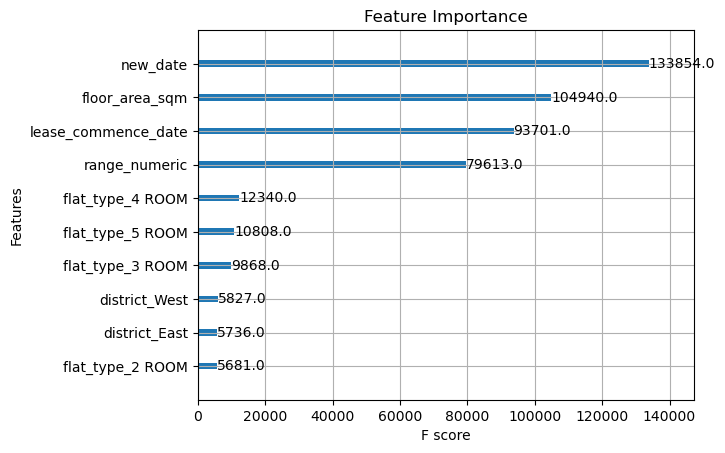

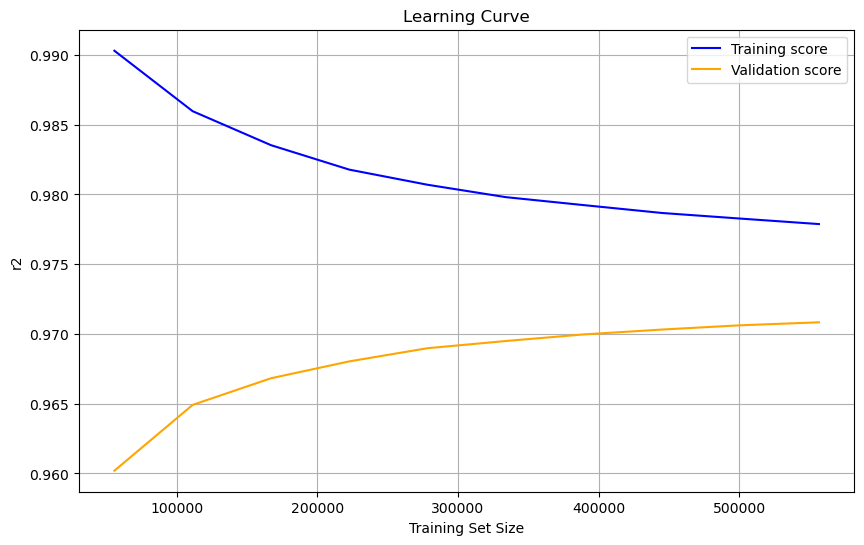

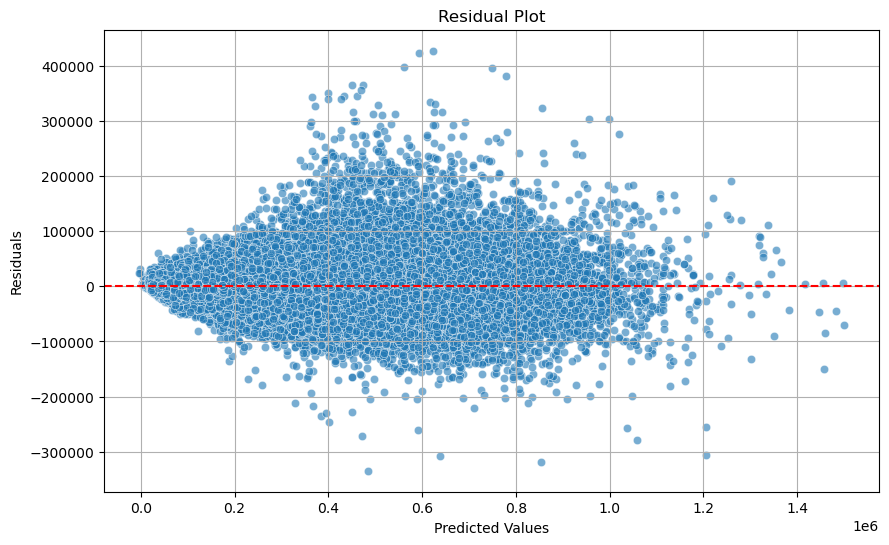

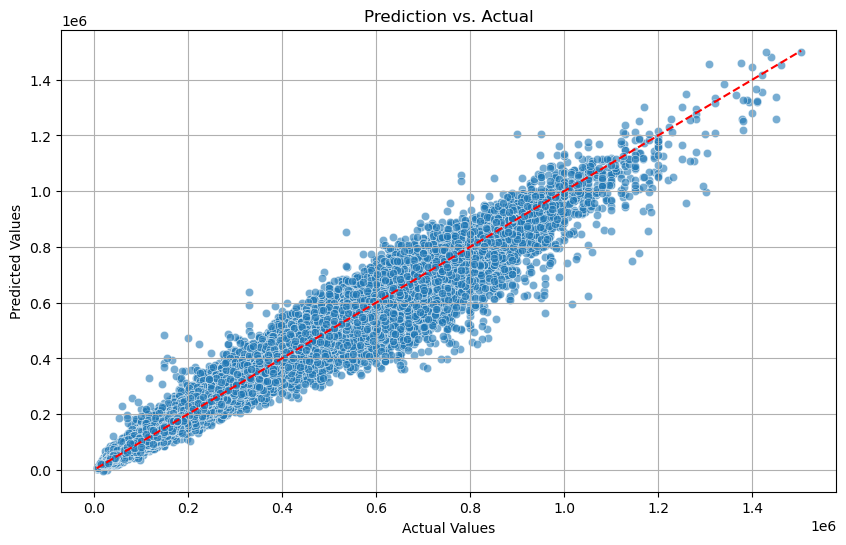

c:\Users\firas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



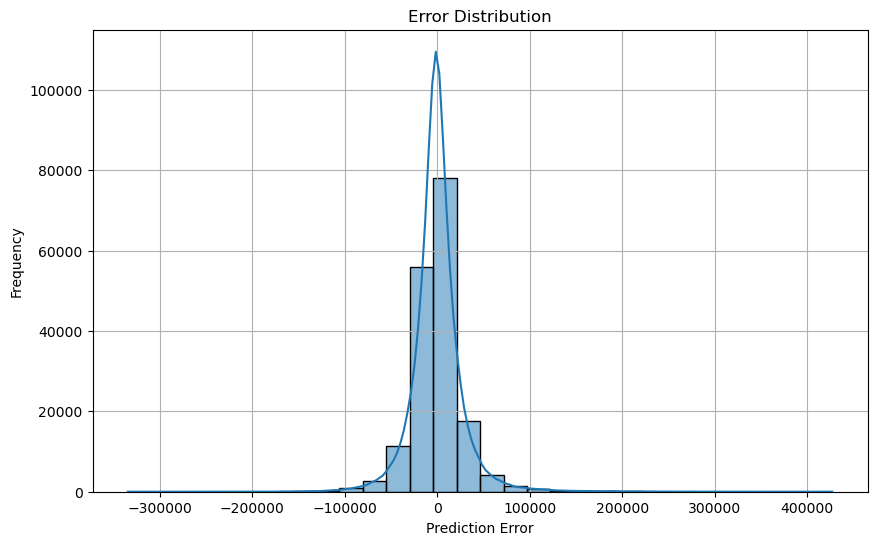

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, mean_absolute_percentage_error
)
from xgboost import plot_importance

# Plot Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation score", color="orange")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

# Prediction vs. Actual Plot
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title("Prediction vs. Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()

# Error Distribution Plot
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(final_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R^2 Scores: {scores}")
print(f"Mean R^2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# Fit model on full training data and evaluate on test set
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Test Metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {explained_variance_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.4f}")

# Plot Feature Importance
plot_importance(final_model, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

# Plot Graphs
plot_learning_curve(final_model, X_train, y_train, cv=kf, scoring='r2')
plot_residuals(y_test, y_pred)
plot_predictions(y_test, y_pred)
plot_error_distribution(y_test, y_pred)


In [31]:
def refined_objective(trial):
    # Use best_params as the center of the refined search space
    best_params = study.best_trial.params
    
    param = {
        'learning_rate': trial.suggest_float(
            'learning_rate', 
            max(0.01, best_params['learning_rate'] - 0.02), 
            min(0.2, best_params['learning_rate'] + 0.02)
        ),
        'n_estimators': trial.suggest_int(
            'n_estimators', 
            max(100, best_params['n_estimators'] - 100), 
            best_params['n_estimators'] + 100
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            max(3, best_params['max_depth'] - 2), 
            best_params['max_depth'] + 2
        ),
        'subsample': trial.suggest_float(
            'subsample', 
            max(0.5, best_params['subsample'] - 0.05), 
            min(1.0, best_params['subsample'] + 0.05)
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 
            max(0.5, best_params['colsample_bytree'] - 0.05), 
            min(1.0, best_params['colsample_bytree'] + 0.05)
        ),
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 
            max(1, best_params['min_child_weight'] - 2), 
            best_params['min_child_weight'] + 2
        ),
        'reg_alpha': trial.suggest_float(
            'reg_alpha', 
            max(0.0, best_params['reg_alpha'] - 0.02), 
            best_params['reg_alpha'] + 0.02
        ),
        'reg_lambda': trial.suggest_float(
            'reg_lambda', 
            max(0.0, best_params['reg_lambda'] - 0.5), 
            best_params['reg_lambda'] + 0.5
        ),
        'gamma': trial.suggest_float(
            'gamma', 
            max(0.0, best_params['gamma'] - 0.05), 
            best_params['gamma'] + 0.05
        )
    }

    # Initialize and evaluate the model using cross-validation
    model = XGBRegressor(**param, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

# Create a new study for fine-tuning
refined_study = optuna.create_study(direction='minimize')
refined_study.optimize(refined_objective, n_trials=50)  # More focused fine-tuning with 50 trials

# Print the new best parameters and RMSE
print("Refined Best Trial:", refined_study.best_trial.params)
print("Refined Best RMSE:", refined_study.best_value)


[I 2025-01-06 22:09:33,426] A new study created in memory with name: no-name-cd4f6121-3b45-43b2-a5ff-71e184d4cb0f
[I 2025-01-06 22:11:18,727] Trial 0 finished with value: 28830.205861033748 and parameters: {'learning_rate': 0.11593435474666526, 'n_estimators': 962, 'max_depth': 8, 'subsample': 0.9829322558260262, 'colsample_bytree': 0.552458170048122, 'min_child_weight': 4, 'reg_alpha': 0.3952458116753995, 'reg_lambda': 4.1426956639363235, 'gamma': 0.5483139121261398}. Best is trial 0 with value: 28830.205861033748.
[I 2025-01-06 22:13:34,970] Trial 1 finished with value: 28431.71544342381 and parameters: {'learning_rate': 0.12549996913889588, 'n_estimators': 1077, 'max_depth': 9, 'subsample': 0.9873644036813314, 'colsample_bytree': 0.5012041120461624, 'min_child_weight': 2, 'reg_alpha': 0.3932712201251216, 'reg_lambda': 4.569680666290502, 'gamma': 0.5688264762319128}. Best is trial 1 with value: 28431.71544342381.
[I 2025-01-06 22:15:24,401] Trial 2 finished with value: 28715.01199661

Refined Best Trial: {'learning_rate': 0.1054304153410666, 'n_estimators': 925, 'max_depth': 10, 'subsample': 0.9950705261882417, 'colsample_bytree': 0.6002792100706928, 'min_child_weight': 3, 'reg_alpha': 0.38619175634455416, 'reg_lambda': 4.591913149467848, 'gamma': 0.6422218743578408}
Refined Best RMSE: 28239.07975936866


In [32]:
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()

In [33]:
best_params_v2 = refined_study.best_trial.params
final_model_v2 = XGBRegressor(**best_params_v2, random_state=42)


Cross-Validation R^2 Scores: [0.97105994 0.97094282 0.97144192 0.97121716 0.97081123]
Mean R^2: 0.9711, Std: 0.0002
Test MSE: 799147389.3384
Test MAE: 18169.3349
Test R^2: 0.9710
Explained Variance: 0.9710
Mean Absolute Percentage Error (MAPE): 0.0646


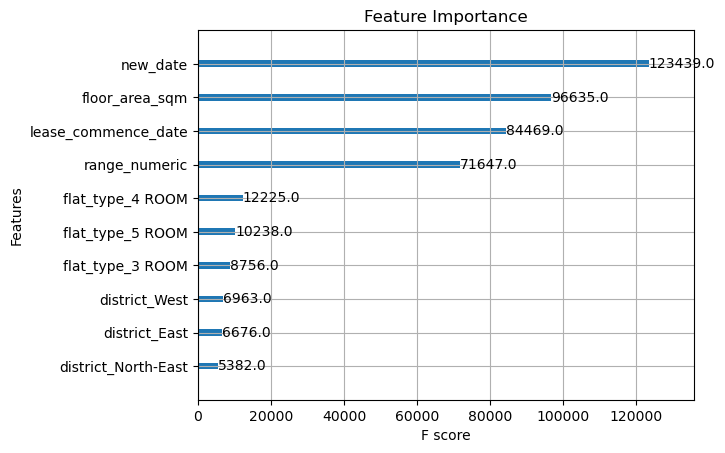

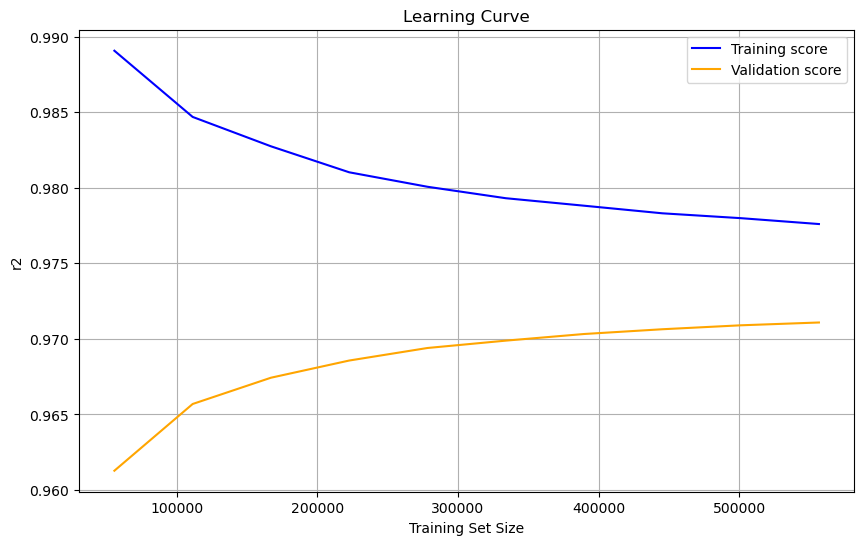

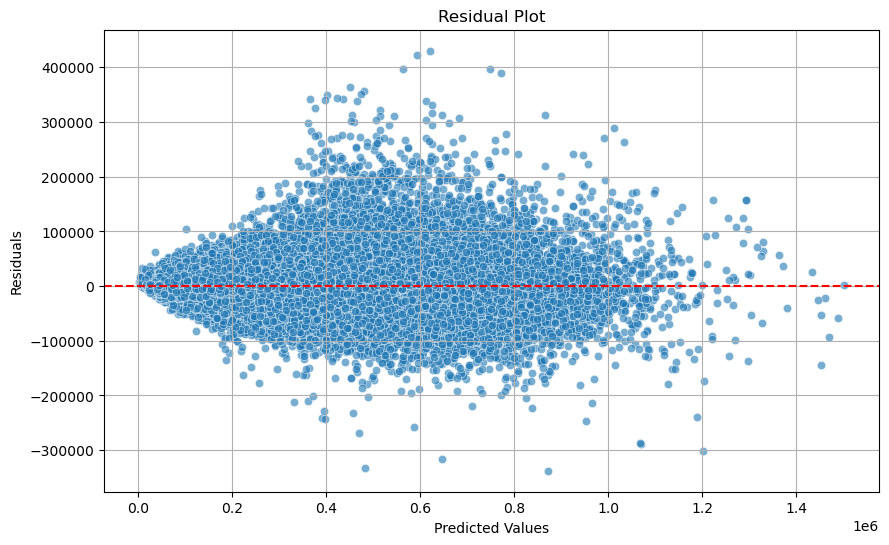

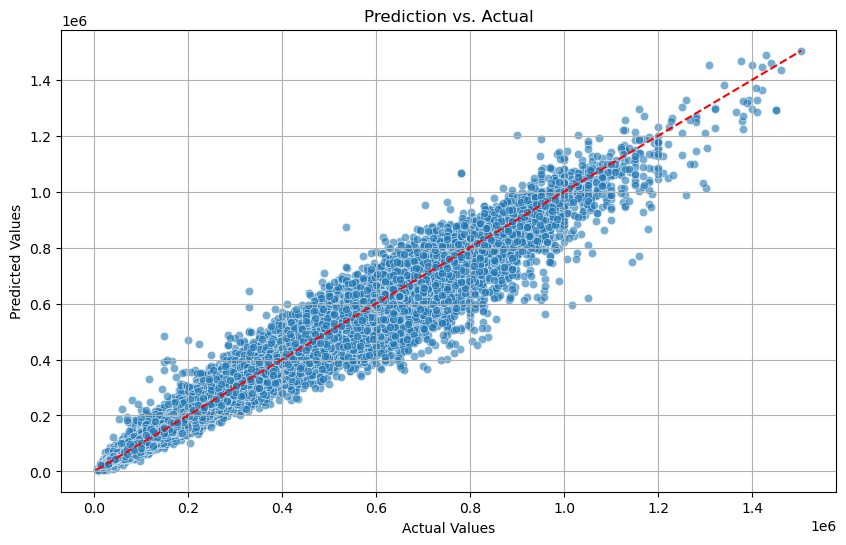

c:\Users\firas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



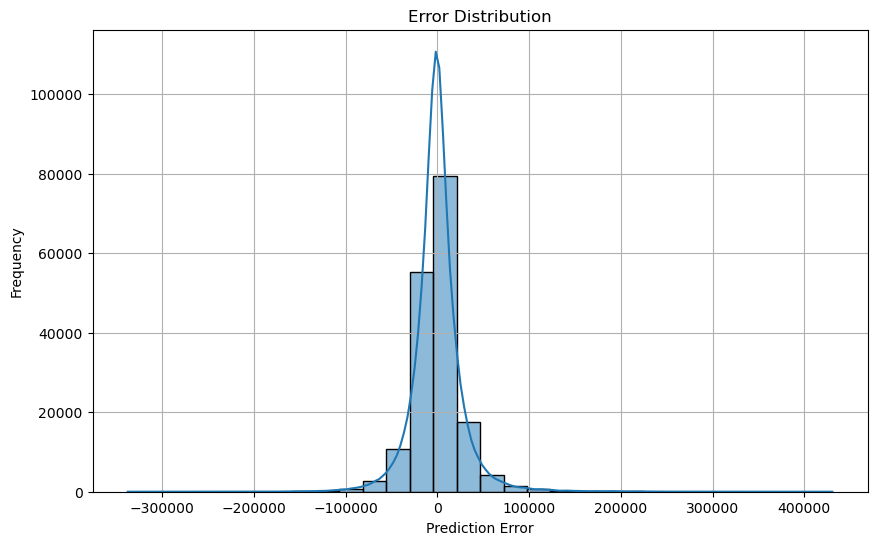

In [34]:


# Plot Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation score", color="orange")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

# Prediction vs. Actual Plot
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title("Prediction vs. Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()

# Error Distribution Plot
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(final_model_v2, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R^2 Scores: {scores}")
print(f"Mean R^2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# Fit model on full training data and evaluate on test set
final_model_v2.fit(X_train, y_train)
y_pred = final_model_v2.predict(X_test)

# Test Metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {explained_variance_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.4f}")

# Plot Feature Importance
plot_importance(final_model_v2, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

# Plot Graphs
plot_learning_curve(final_model_v2, X_train, y_train, cv=kf, scoring='r2')
plot_residuals(y_test, y_pred)
plot_predictions(y_test, y_pred)
plot_error_distribution(y_test, y_pred)


In [ ]:
y_pred = final_model_v2.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()


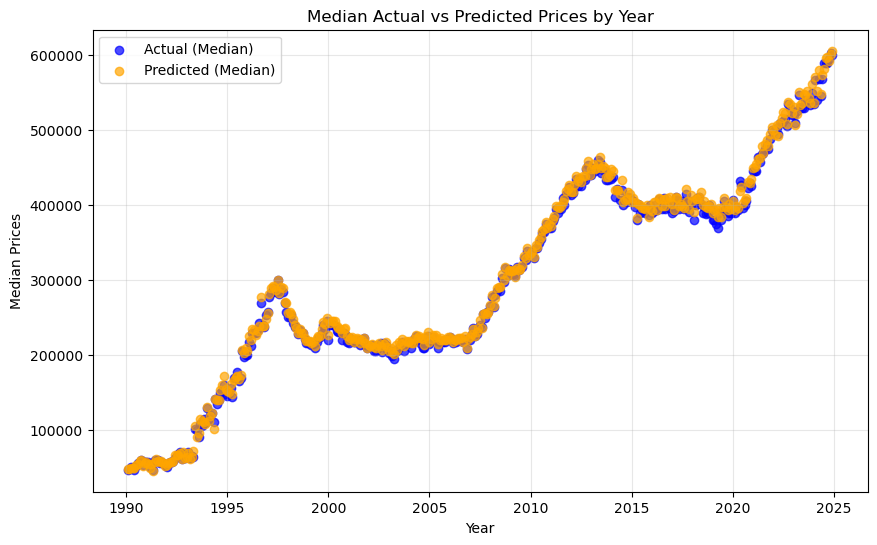

In [35]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [36]:
joblib.dump(final_model_v2,'new_model_v1.pkl')

['new_model_v1.pkl']

In [20]:
# Random Forest Model with Optimized Parameters
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    min_samples_split=6,
    min_samples_leaf =1        
        
)

# Gradient Boosting Model
xgb_model = XGBRegressor(
    objective = 'reg:squarederror',
    learning_rate= 0.11280965749520883,
    n_estimators= 650, 
    random_state=42
)



In [21]:
# Training Models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

KeyboardInterrupt: 

Random Forest MSE: 1037976499.05, R²: 0.96
XGBoost MSE: 937943215.92, R²: 0.97
Ensemble MSE: 925207277.16, R²: 0.97


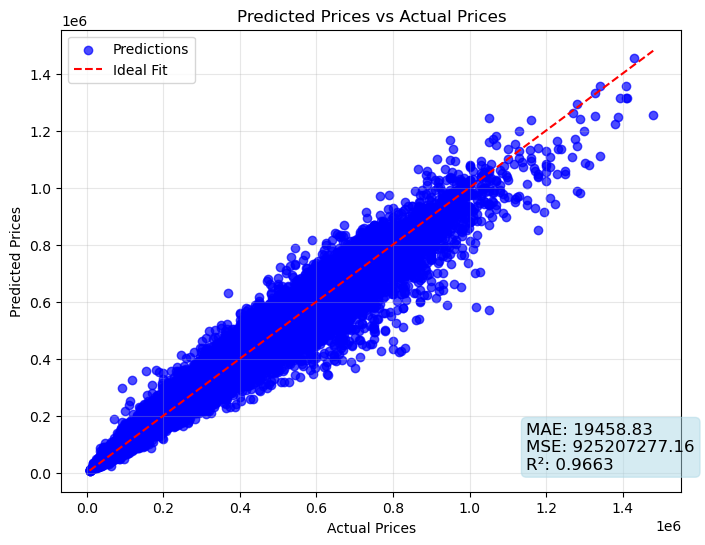

In [ ]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Models
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
rf_mse = mean_squared_error(y_test, y_pred_rf)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
rf_r2 = r2_score(y_test, y_pred_rf)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"Random Forest MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")

# Ensemble (Averaging Predictions)
ensemble_pred = (y_pred_rf + y_pred_xgb) / 2
ensemble_mae = mean_absolute_error(y_test,ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble MSE: {ensemble_mse:.2f}, R²: {ensemble_r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()





In [ ]:
from sklearn.metrics import mean_squared_error

train_losses = []
val_losses = []

for train_size in train_sizes:
    X_partial = X_train[:train_size]
    y_partial = y_train[:train_size]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_partial, y_partial)
    
    # Training Loss
    train_pred = model.predict(X_partial)
    train_loss = mean_squared_error(y_partial, train_pred)
    train_losses.append(train_loss)
    
    # Validation Loss
    val_pred = model.predict(X_test)
    val_loss = mean_squared_error(y_test, val_pred)
    val_losses.append(val_loss)


In [19]:
import xgboost as xgb

# Define the model with early stopping and loss tracking
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Extract training and validation loss
results = model.evals_result()
train_loss = results['validation_0']['rmse']
val_loss = results['validation_1']['rmse']


[0]	validation_0-rmse:125611.62118	validation_1-rmse:125289.30973
[1]	validation_0-rmse:98553.60555	validation_1-rmse:98249.13385
[2]	validation_0-rmse:80570.44763	validation_1-rmse:80362.35759
[3]	validation_0-rmse:69467.05530	validation_1-rmse:69324.77475
[4]	validation_0-rmse:61325.88421	validation_1-rmse:61225.07813
[5]	validation_0-rmse:56488.72109	validation_1-rmse:56445.39425
[6]	validation_0-rmse:52264.89560	validation_1-rmse:52301.79123
[7]	validation_0-rmse:50154.73763	validation_1-rmse:50256.89439
[8]	validation_0-rmse:47071.30442	validation_1-rmse:47288.19080
[9]	validation_0-rmse:45438.40044	validation_1-rmse:45741.26119
[10]	validation_0-rmse:43544.53872	validation_1-rmse:43942.07068
[11]	validation_0-rmse:42520.61313	validation_1-rmse:42961.48343
[12]	validation_0-rmse:41011.04519	validation_1-rmse:41506.26356
[13]	validation_0-rmse:40513.48087	validation_1-rmse:41054.41125
[14]	validation_0-rmse:39964.21276	validation_1-rmse:40558.86071
[15]	validation_0-rmse:39474.2127

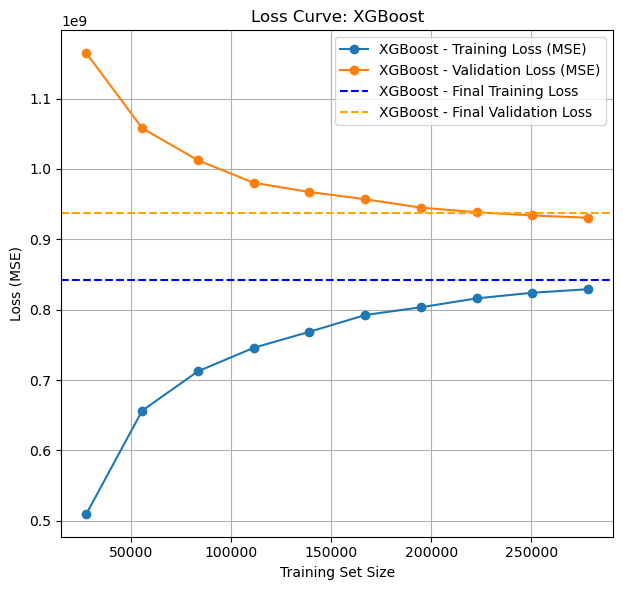

In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a function to compute and plot learning curves along with loss curves
def plot_learning_and_loss_curve(model, model_name, X, y, X_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    
    # Convert negative MSE to positive
    train_losses = -train_scores.mean(axis=1)
    val_losses = -val_scores.mean(axis=1)
    
    # Train the model on the full training set for loss tracking
    model.fit(X, y)
    
    # Compute loss on full training and validation sets
    y_train_pred = model.predict(X)
    y_val_pred = model.predict(X_val)
    train_loss = mean_squared_error(y, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    # Plot the learning curve
    plt.plot(train_sizes, train_losses, label=f'{model_name} - Training Loss (MSE)', marker='o')
    plt.plot(train_sizes, val_losses, label=f'{model_name} - Validation Loss (MSE)', marker='o')
    plt.axhline(y=train_loss, color='blue', linestyle='--', label=f'{model_name} - Final Training Loss')
    plt.axhline(y=val_loss, color='orange', linestyle='--', label=f'{model_name} - Final Validation Loss')
    plt.xlabel('Training Set Size')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Loss Curve: {model_name}')
    plt.legend()
    plt.grid(True)

# Plot learning and loss curves for Random Forest
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_learning_and_loss_curve(rf_model, 'Random Forest', X_train, y_train, X_test, y_test)

# Plot learning and loss curves for XGBoost
plt.subplot(1, 2, 2)
plot_learning_and_loss_curve(xgb_model, 'XGBoost', X_train, y_train, X_test, y_test)

plt.tight_layout()
plt.show()


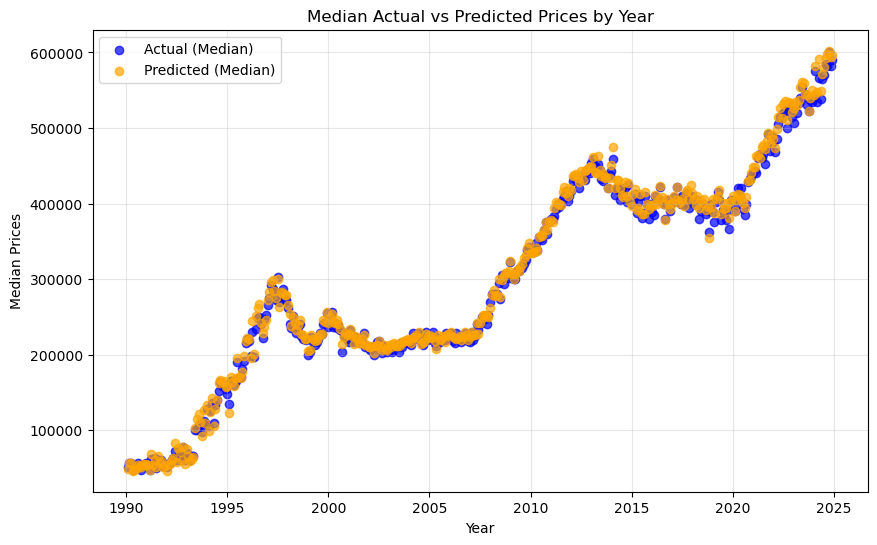

In [18]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred_rf
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [23]:

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

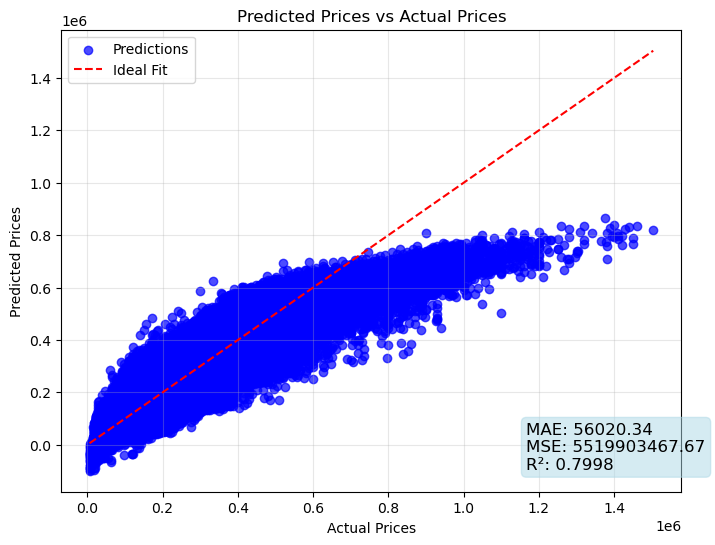

In [24]:
y_pred = lin_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

In [27]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

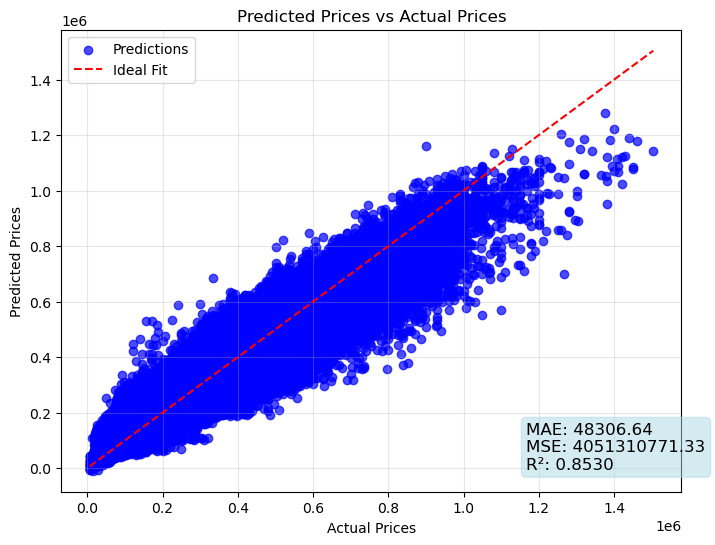

In [28]:
y_pred = poly_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

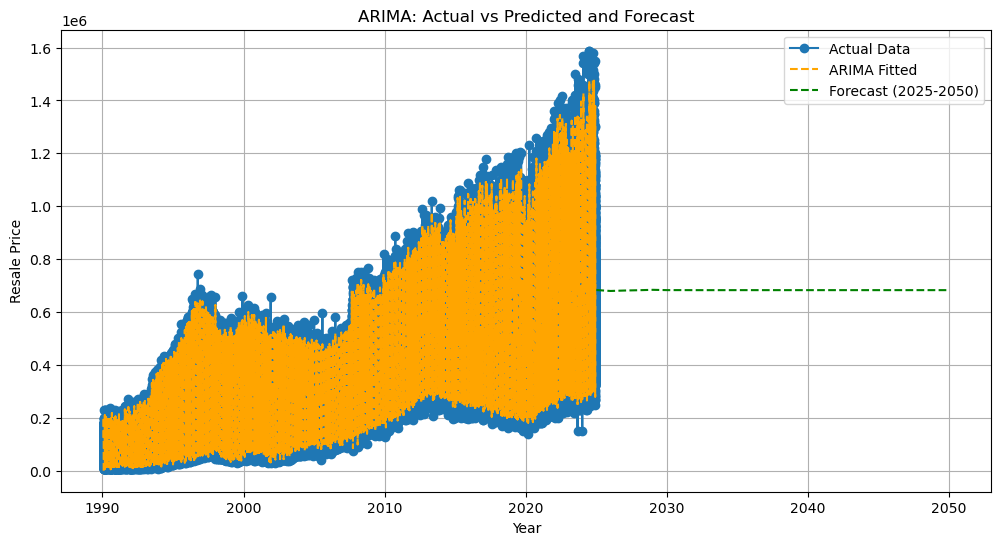

(3348885939.132387, 27700.24892551467, 0.8788192370629987)

In [30]:

# Assuming 'resale_price' is indexed by 'new_date'
time_series_data = data[['new_date', 'resale_price']].set_index('new_date')

# Fit ARIMA model
model = ARIMA(time_series_data, order=(5, 1, 0))
arima_fit = model.fit()

# Forecast future values (2024 to 2050)
future_forecast = arima_fit.forecast(steps=26)
forecast_years = np.arange(2025, 2051)

# Combine actual and forecast data for comparison
combined_data = pd.concat([time_series_data, pd.Series(future_forecast, index=forecast_years)])

# Metrics calculation (for training period)
train_actual = time_series_data.values
train_pred = arima_fit.fittedvalues

mse = mean_squared_error(train_actual, train_pred)
mae = mean_absolute_error(train_actual, train_pred)
r2 = r2_score(train_actual, train_pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data.values, label="Actual Data", marker='o')
plt.plot(time_series_data.index, train_pred, label="ARIMA Fitted", linestyle='--', color='orange')
plt.plot(forecast_years, future_forecast, label="Forecast (2025-2050)", linestyle='--', color='green')
plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.title("ARIMA: Actual vs Predicted and Forecast")
plt.legend()
plt.grid(True)
plt.show()

mse, mae, r2


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
import numpy as np

def objective(trial):
    # Define hyperparameter search space for RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 30, log=True),  # Depth of each tree
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Minimum samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),    # Minimum samples in each leaf
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),       # Fraction of features to consider
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Bootstrap sampling
    }

    # Initialize RandomForestRegressor with current parameters
    model = RandomForestRegressor(**param, random_state=42)

    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())  # Convert negative MSE to RMSE
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best trial
print("Best Trial:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-01-07 10:40:39,411] A new study created in memory with name: no-name-11a01c21-565e-498b-bc29-c3dc6e7496be
[I 2025-01-07 10:45:25,796] Trial 0 finished with value: 36541.12190614621 and parameters: {'n_estimators': 140, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 0.7716551620304883, 'bootstrap': True}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:51:30,786] Trial 1 finished with value: 60471.3594004906 and parameters: {'n_estimators': 151, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.9286514690332781, 'bootstrap': False}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:53:38,123] Trial 2 finished with value: 63034.08366993758 and parameters: {'n_estimators': 191, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.10850588592337093, 'bootstrap': False}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:55:04,884] Trial 3 finished

Best Trial: {'n_estimators': 138, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.6283551656067656, 'bootstrap': False}
Best RMSE: 30861.940280609644


In [12]:
best_params_rf = study.best_trial.params
model_rf = RandomForestRegressor(**best_params_rf, random_state=42)


In [14]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=22,
                      max_features=0.6283551656067656, min_samples_leaf=7,
                      min_samples_split=12, n_estimators=138, random_state=42)

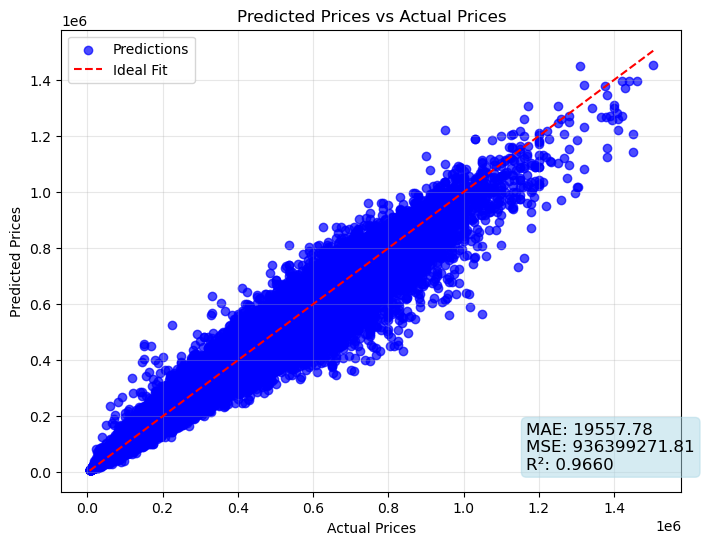

In [15]:
y_pred = model_rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

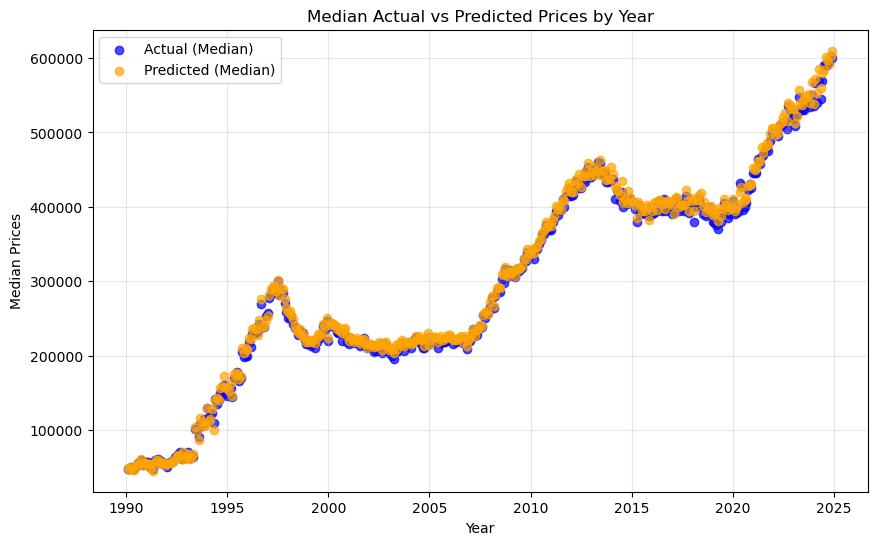

In [17]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [19]:
joblib.dump(model_rf,'new_model_rf.pkl')

['new_model_rf.pkl']